# SVHN BBOX FIRST NUMBER DETECTION

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
#torch.cuda.set_device(0)

import pandas as pd

## Download Data

In [3]:
PATH = Path('data/svhn/')

In [1]:
#os.makedirs('data/svhn/', exist_ok=True)
#!wget -P {PATH} http://ufldl.stanford.edu/housenumbers/train.tar.gz
#!tar -xvf {PATH}/train.tar.gz -C {PATH}
#!wget -P {PATH} https://github.com/tcvieira/fun-with-fastai/raw/master/lesson8/digitStruct.csv

In [20]:
list(PATH.iterdir())

[PosixPath('data/svhn/.DS_Store'),
 PosixPath('data/svhn/digitStruct.csv'),
 PosixPath('data/svhn/train')]

In [21]:
IMGS = 'train'
IMGS_PATH = PATH/IMGS
images = []
for i, obj in enumerate(IMGS_PATH.glob('*.png')):
    #print(f'{i} : {obj.name}')
    images.append(obj)
len(images)

33402

In [22]:
images[0].name

'20037.png'

## Read .mat file

Use https://github.com/prijip/Py-Gsvhn-DigitStruct-Reader

In [23]:
df = pd.read_csv('data/svhn/digitStruct.csv')
print(len(df))
df.head()

73257


,FileName,DigitLabel,Left,Top,Width,Height
0,1.png,1,246,77,81,219
1,1.png,9,323,81,96,219
2,2.png,2,77,29,23,32
3,2.png,3,98,25,26,32
4,3.png,2,17,5,8,15


Get only the first digit bbox

In [24]:
df.drop_duplicates(subset='FileName', inplace=True, keep='first')
print(len(df))
df.head()

33402


,FileName,DigitLabel,Left,Top,Width,Height
0,1.png,1,246,77,81,219
2,2.png,2,77,29,23,32
4,3.png,2,17,5,8,15
6,4.png,9,57,13,15,34
8,5.png,3,52,7,21,46


In [13]:
df.reset_index(inplace=True, drop=True)
df.head()

,FileName,DigitLabel,Left,Top,Width,Height
0,1.png,1,246,77,81,219
1,2.png,2,77,29,23,32
2,3.png,2,17,5,8,15
3,4.png,9,57,13,15,34
4,5.png,3,52,7,21,46


## Data Wrangling

In [14]:
cats = {index:row['DigitLabel'] for index, row in df.iterrows()}
trn_fns = {index:row['FileName'] for index, row in df.iterrows()}
trn_ids = [index for index, row in df.iterrows()]
#trn_ids

In [16]:
list(IMGS_PATH.iterdir())[:5]

[PosixPath('data/svhn/train/27087.png'),
 PosixPath('data/svhn/train/21069.png'),
 PosixPath('data/svhn/train/20806.png'),
 PosixPath('data/svhn/train/14412.png'),
 PosixPath('data/svhn/train/19821.png')]

**Each image has a unique ID which was generated as the array index, since csv file does not provide it.**

In [17]:
df.FileName[0], df.index[0]

('1.png', 0)

Here we create a dict from image IDs to a list of annotations (tuple of bounding box and class id).

We convert SVHN's height/width into top-left/bottom-right, and switch x/y coords to be consistent with numpy.

In [18]:
def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

trn_anno = collections.defaultdict(lambda:[])
for index, row in df.iterrows():
    bb = [row['Left'], row['Top'], row['Width'], row['Height']]
    bb = hw_bb(bb)
    trn_anno[index].append((bb,cats[index]))
        
print(len(trn_anno))
#trn_anno

33402


In [19]:
img_anno = trn_anno[0]
img_anno

[(array([ 77, 246, 295, 326]), 1)]

**1 is already the category of the bbox**

In [20]:
img0_anno = img_anno[0]
img0_anno

(array([ 77, 246, 295, 326]), 1)

**All images only have one bbox in trn_anno, but as it is an array we can later add all bbox**

In [21]:
trn_anno[4]

[(array([ 7, 52, 52, 72]), 3)]

Some libs take VOC format bounding boxes, so this let's us convert back when required:

In [22]:
bb_voc = [155, 96, 196, 174]
bb_fastai = hw_bb(bb_voc)

In [23]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

In [24]:
f'expected: {bb_voc}, actual: {bb_hw(bb_fastai)}'

'expected: [155, 96, 196, 174], actual: [155  96 196 174]'

## Draw Images

In [34]:
im = open_image(IMGS_PATH/trn_fns[0])

In [35]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [36]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [37]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [38]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

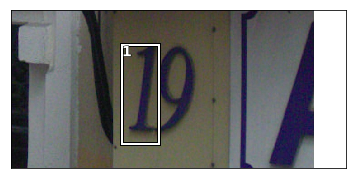

In [39]:
ax = show_img(im)
b = bb_hw(img0_anno[0])
draw_rect(ax, b)
draw_text(ax, b[:2], str(img0_anno[1]))

In [40]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        
        draw_text(ax, b[:2], str(c), sz=16)

In [43]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMGS_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

(78, 156, 3)


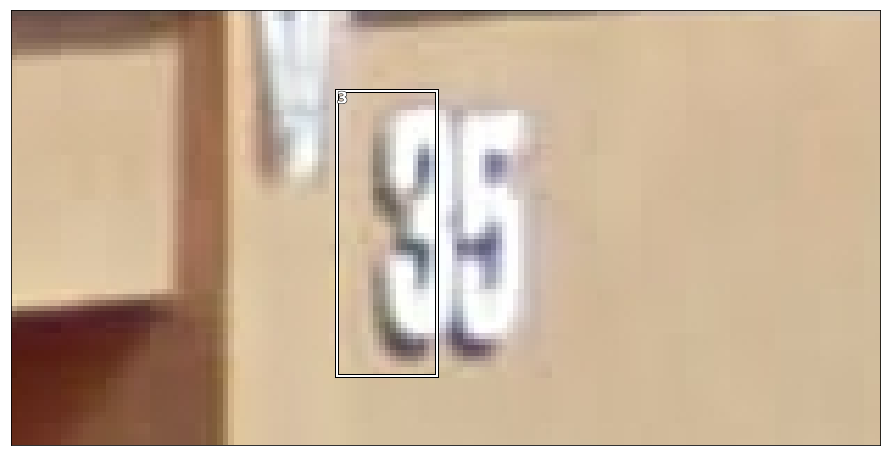

In [44]:
draw_idx(101)

## First Number Classifier

**As we only have one bbox on trn_anno, so we train on it**

In [45]:
trn_first_anno = {a: b[0] for a,b in trn_anno.items()}

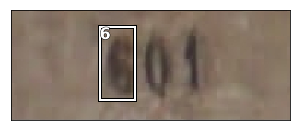

In [47]:
b,c = trn_first_anno[24]
b = bb_hw(b)
ax = show_img(open_image(IMGS_PATH/trn_fns[24]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], str(c), sz=16)

In [48]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/first.csv'

Often it's easiest to simply create a CSV of the data you want to model, rather than trying to create a custom dataset. Here we use Pandas to help us create a CSV of the image filename and class.

In [49]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
    'cat': [str(trn_first_anno[o][1]) for o in trn_ids]}, columns=['fn','cat'])
df.to_csv(CSV, index=False)

In [50]:
f_model = resnet34
sz=224
bs=64

Dogs vs Cats FTW!

In [51]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, IMGS, CSV, tfms=tfms, bs=bs)

In [52]:
x,y=next(iter(md.val_dl))

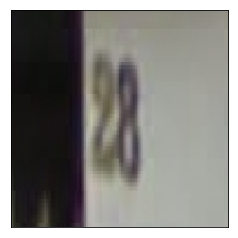

In [55]:
show_img(md.val_ds.denorm(to_np(x))[0]);

In [62]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [63]:
lrf=learn.lr_find(1e-5,100)

 65%|██████▍   | 271/418 [00:54<00:29,  4.99it/s, loss=8.29]

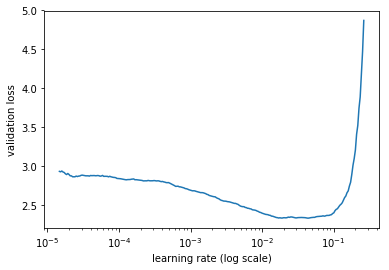

In [64]:
learn.sched.plot()

In [66]:
lr = 2e-3

In [67]:
learn.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.938986   1.81685    0.361527  


[array([1.81685]), 0.3615269461077844]

In [68]:
lrs = np.array([lr/1000,lr/100,lr])

In [69]:
learn.freeze_to(-2)

 77%|███████▋  | 320/418 [01:51<00:34,  2.86it/s, loss=6.76]

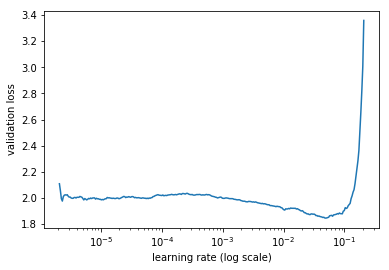

In [70]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [71]:
learn.fit(lrs/5, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.852264   1.762562   0.36991   


[array([1.76256]), 0.36991017967641]

In [73]:
learn.fit(1e-3, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.287456   1.181224   0.613024  


[array([1.18122]), 0.6130239520244256]

In [74]:
learn.unfreeze()

In [75]:
learn.fit(1e-3, 1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.845747   0.675809   0.790719  
    1      0.618245   0.56157    0.823054                    


[array([0.56157]), 0.8230538922155689]

In [76]:
learn.save('first_one')

In [77]:
learn.load('first_one')

In [78]:
x,y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x,preds = to_np(x),to_np(probs)
preds = np.argmax(preds, -1)

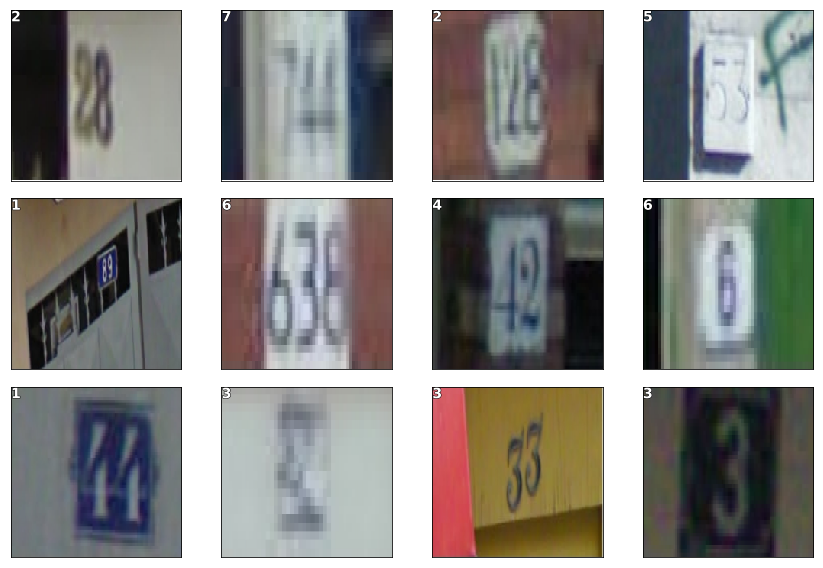

In [94]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    #pdb.set_trace()
    ima=md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    #draw_text(ax, (0,0), b)
    text = ax.text(0, 0, b, verticalalignment='top', color='white', fontsize=14, weight='bold')
    draw_outline(text, 1)
plt.tight_layout()

## Bbox only

Now we'll try to find the bounding box of the first number. This is simply a regression with 4 outputs. So we can use a CSV with multiple 'labels'.

In [95]:
BB_CSV = PATH/'tmp/bb.csv'

In [96]:
bb = np.array([trn_first_anno[o][0] for o in trn_ids])
bbs = [' '.join(str(p) for p in o) for o in bb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns=['fn','bbox'])
df.to_csv(BB_CSV, index=False)

In [97]:
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 '1.png,77 246 295 326\n',
 '2.png,29 77 60 99\n',
 '3.png,5 17 19 24\n',
 '4.png,13 57 46 71\n']

In [101]:
f_model=resnet34
sz=224
bs=64

Set `continuous=True` to tell fastai this is a regression problem, which means it won't one-hot encode the labels, and will use MSE as the default crit.

Note that we have to tell the transforms constructor that our labels are coordinates, so that it can handle the transforms correctly.

Also, we use CropType.NO because we want to 'squish' the rectangular images into squares, rather than center cropping, so that we don't accidentally crop out some of the objects. (This is less of an issue in something like imagenet, where there is a single object to classify, and it's generally large and centrally located).

In [102]:
augs = [RandomFlip(), 
        RandomRotate(30),
        RandomLighting(0.1,0.1)]

In [103]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, IMGS, BB_CSV, tfms=tfms, continuous=True, bs=4)

[52. 12. 28. 41.]
[52. 12. 28. 41.]
[52. 12. 28. 41.]
[52. 12. 28. 41.]
[52. 12. 28. 41.]
[52. 12. 28. 41.]
[52. 12. 28. 41.]
[52. 12. 28. 41.]
[52. 12. 28. 41.]


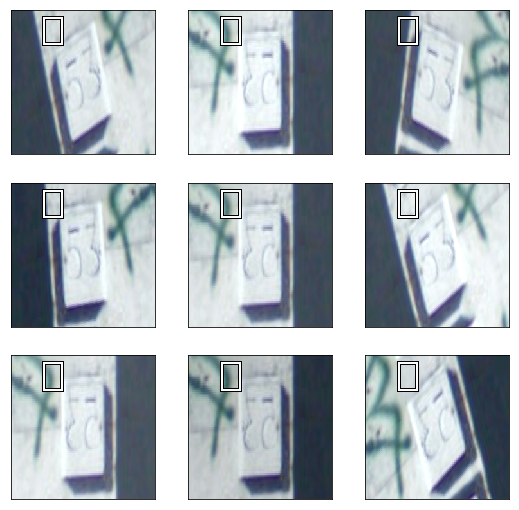

In [104]:
idx=3
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [105]:
augs = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(30, tfm_y=TfmType.COORD),
        RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]

In [107]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, IMGS, BB_CSV, tfms=tfms, continuous=True, bs=4)

[ 70.  20.  47. 125.]
[ 70.  19.  47. 126.]
[ 73.  35.  36. 113.]
[107.  20.  47. 125.]
[ 61.  46.  56. 133.]
[114.  35.  37. 113.]
[108.  44.  55. 133.]
[115.  35.  36. 112.]
[ 67.  38.  45. 123.]


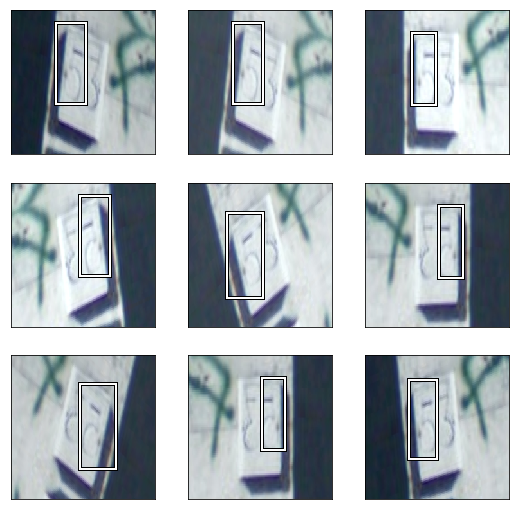

In [108]:
idx=3
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [110]:
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y),
        RandomRotate(3, p=0.5, tfm_y=tfm_y),
        RandomLighting(0.05,0.05, tfm_y=tfm_y)]

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, IMGS, BB_CSV, tfms=tfms, bs=bs, continuous=True)

fastai let's you use a `custom_head` to add your own module on top of a convnet, instead of the adaptive pooling and fully connected net which is added by default. In this case, we don't want to do any pooling, since we need to know the activations of each grid cell.

The final layer has 4 activations, one per bounding box coordinate. Our target is continuous, not categorical, so the MSE loss function used does not do any sigmoid or softmax to the module outputs.

In [111]:
512*7*7

25088

In [112]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [113]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

 63%|██████▎   | 263/418 [00:58<00:34,  4.49it/s, loss=99]  

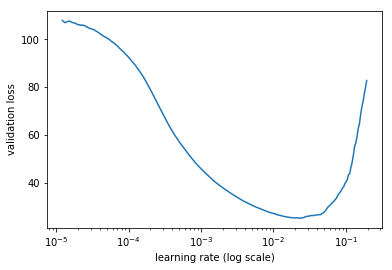

In [114]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [115]:
lr = 2e-3

In [116]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                              
    0      16.653218  15.567973 
    1      15.895033  15.285529                             
    2      14.943266  14.865288                             


[array([14.86529])]

In [117]:
lrs = np.array([lr/100,lr/10,lr])

In [118]:
learn.freeze_to(-2)

 99%|█████████▉| 414/418 [02:27<00:01,  2.80it/s, loss=65.8]

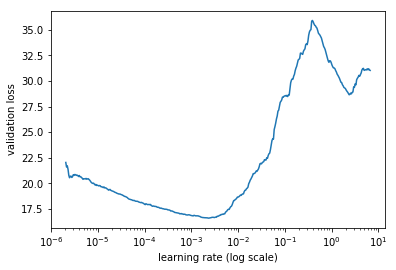

In [119]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [120]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                              
    0      10.276601  9.863893  
    1      9.545119   11.042176                             
    2      7.644388   7.884708                              


[array([7.88471])]

In [121]:
learn.freeze_to(-3)

In [122]:
learn.fit(lrs, 1, cycle_len=2)

epoch      trn_loss   val_loss                              
    0      9.220912   9.070111  
    1      7.271217   7.773306                              


[array([7.77331])]

In [123]:
learn.save('reg4')

In [124]:
learn.load('reg4')

In [125]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

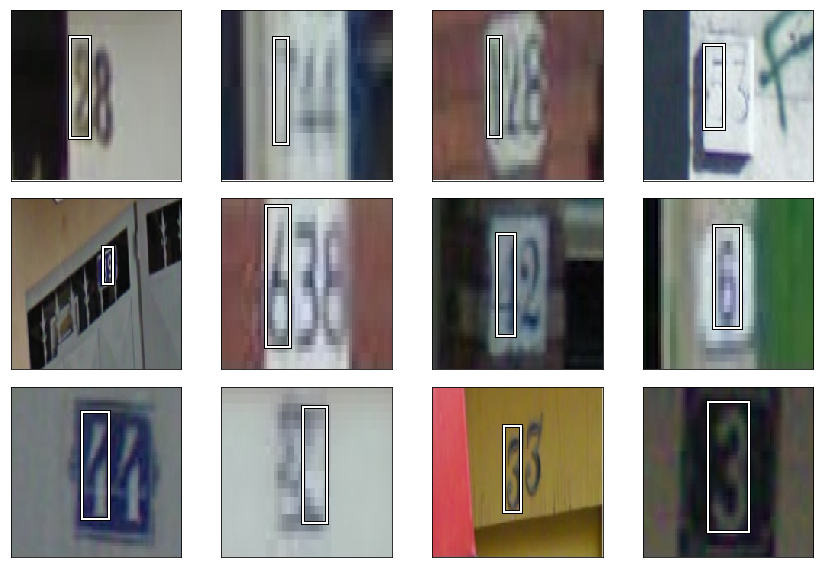

In [126]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

## Single object detection


In [127]:
f_model=resnet34
sz=224
bs=64

val_idxs = get_cv_idxs(len(trn_fns))

In [129]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, IMGS, BB_CSV, tfms=tfms,
   bs=bs, continuous=True, val_idxs=val_idxs)

In [130]:
md2 = ImageClassifierData.from_csv(PATH, IMGS, CSV, tfms=tfms_from_model(f_model, sz))

A dataset can be anything with `__len__` and `__getitem__`. Here's a dataset that adds a 2nd label to an existing dataset:

In [131]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

We'll use it to add the classes to the bounding boxes labels.

In [133]:
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)

In [134]:
val_ds2[0][1]

(array([ 42.,  80., 169., 105.], dtype=float32), 2)

We can replace the dataloaders' datasets with these new ones.

In [135]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

We have to `denorm`alize the images from the dataloader before they can be plotted.

In [136]:
x,y=next(iter(md.val_dl))
idx=3
ima=md.val_ds.ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[0][idx])); b

array([ 73.,  35.,  37., 114.])

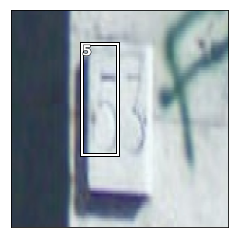

In [140]:
ax = show_img(ima)
draw_rect(ax, b)
#draw_text(ax, b[:2], md2.classes[y[1][idx]])
text = ax.text(b[0], b[1], md2.classes[y[1][idx]], verticalalignment='top', color='white', fontsize=14, weight='bold')
draw_outline(text, 1)

We need one output activation for each class (for its probability) plus one for each bounding box coordinate. We'll use an extra linear layer this time, plus some dropout, to help us train a more flexible model.

In [139]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [141]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

 79%|███████▊  | 329/418 [01:14<00:20,  4.39it/s, loss=281] 

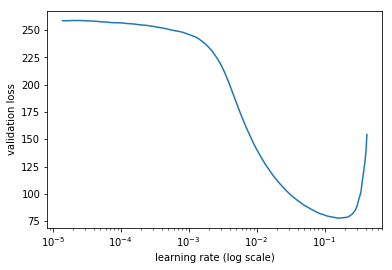

In [142]:
learn.lr_find()
learn.sched.plot()

In [143]:
lr=1e-2

In [148]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))
#learn.fit(lr, 1, cycle_len=3)

epoch      trn_loss   val_loss   detn_acc   detn_l1         
    0      50.478868  46.483213  0.429341   13.499942 
    1      49.234008  46.548864  0.436976   14.143883       
    2      47.236558  45.766296  0.44476    14.096927       


[array([45.7663]), 0.44476047897053334, 14.096927048917301]

In [149]:
learn.save('reg1_0')

In [150]:
learn.freeze_to(-2)

In [151]:
lrs = np.array([lr/100, lr/10, lr])

 74%|███████▍  | 310/418 [01:56<00:40,  2.65it/s, loss=161] 

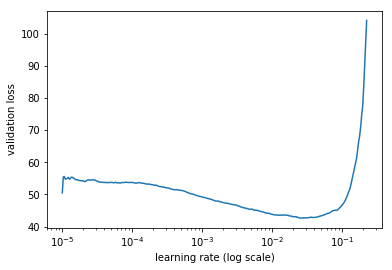

In [152]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [153]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

epoch      trn_loss   val_loss   detn_acc   detn_l1         
    0      29.425933  25.06278   0.76482    10.237989 
    1      22.431148  22.657357  0.801647   9.638225        
    2      19.094628  20.061404  0.831737   8.786842        
    3      16.505865  18.932992  0.848353   8.376871        
    4      13.102533  17.827384  0.86497    7.957223        


[array([17.82738]), 0.8649700599516223, 7.957222852307165]

In [154]:
learn.save('reg1_1')

In [158]:
learn.load('reg1_1')

it is taking to long... acc it is good enough for now

In [156]:
#learn.unfreeze()

In [159]:
#learn.fit(lrs/10, 1, cycle_len=5, use_clr=(32,10))

In [ ]:
#learn.save('reg1')

In [160]:
#learn.load('reg1')

In [161]:
y = learn.predict()
x,_ = next(iter(md.val_dl))

In [162]:
from scipy.special import expit

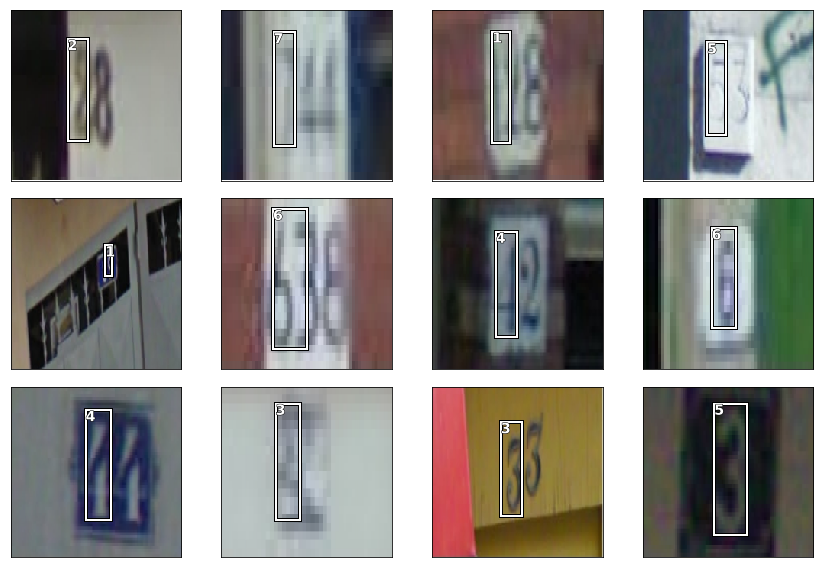

In [164]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    #draw_text(ax, b[:2], md2.classes[c])
    text = ax.text(b[0], b[1], md2.classes[c], verticalalignment='top', color='white', fontsize=14, weight='bold')
    draw_outline(text, 1)
plt.tight_layout()